https://medium.com/data-science/build-your-own-transformer-from-scratch-using-pytorch-84c850470dcb

https://github.com/jadore801120/attention-is-all-you-need-pytorch/blob/master/learn_bpe.py

https://github.com/tensorflow/tensor2tensor/blob/master/tensor2tensor/models/transformer.py

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math
import random
import os
import re
import matplotlib.pyplot as plt

class CustomTokenizer:
    def __init__(self, specials=["<PAD>", "<UNK>", "<BOS>", "<EOS>"]):
        self.specials = specials
        self.token2idx = {}
        self.idx2token = []
        for sp in specials:
            self.add_token(sp)
        self.pad_token = "<PAD>"
        self.unk_token = "<UNK>"
        self.bos_token = "<BOS>"
        self.eos_token = "<EOS>"

    def add_token(self, token):
        if token not in self.token2idx:
            self.token2idx[token] = len(self.idx2token)
            self.idx2token.append(token)

    def build_vocab(self, text_lines):
        """
        Build the vocab by lowercasing and regex-based tokenization.
        """
        for line in text_lines:
            line = line.lower()  # Convert to lowercase
            # Extract "word" tokens OR any single non-whitespace char (e.g. punctuation)
            tokens = re.findall(r"\w+|[^\w\s]", line)
            for t in tokens:
                self.add_token(t)

    def encode(self, text_line, add_bos_eos=False):
        """
        Convert a text line into token IDs using the same regex approach.
        """
        text_line = text_line.lower()
        tokens = re.findall(r"\w+|[^\w\s]", text_line)
        ids = []
        if add_bos_eos:
            ids.append(self.token2idx[self.bos_token])
        for t in tokens:
            if t in self.token2idx:
                ids.append(self.token2idx[t])
            else:
                ids.append(self.token2idx[self.unk_token])
        if add_bos_eos:
            ids.append(self.token2idx[self.eos_token])
        return ids

    def decode(self, token_ids):
        """Convert a list of token IDs back into a string."""
        tokens = []
        for i in token_ids:
            tokens.append(self.idx2token[i])
        return " ".join(tokens)
    
    def __len__(self):
        return len(self.idx2token)

class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing, vocab_size, ignore_index=None):
        super().__init__()
        self.smoothing = smoothing
        self.vocab_size = vocab_size
        self.ignore_index = ignore_index

    def forward(self, log_probs, target):
        """
        log_probs: (batch_size*seq_len, vocab_size) [already passed through log_softmax]
        target:    (batch_size*seq_len)
        """
        # Confidence for the true class:
        confidence = 1.0 - self.smoothing
        # Amount to distribute over all other classes:
        smoothing_value = self.smoothing / (self.vocab_size - 1)

        # Create full one-hot distribution with smoothing
        with torch.no_grad():
            true_dist = torch.full_like(log_probs, smoothing_value)
            true_dist.scatter_(1, target.unsqueeze(1), confidence)

            # If ignore_index is set, zero out those entries
            if self.ignore_index is not None:
                ignore_mask = (target == self.ignore_index).unsqueeze(1)
                true_dist.masked_fill_(ignore_mask, 0.0)

        loss = -torch.sum(true_dist * log_probs, dim=1).mean()
        return loss

def get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps):
    """
    Cosine decay to 0, with a linear warm-up at the start.
    """
    def lr_lambda(current_step):
        if current_step < warmup_steps:
            return float(current_step) / float(max(1, warmup_steps))
        # progress after warmup
        progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
        # Cosine decay from 1 -> 0
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * progress)))

    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

def train_model(train_x, train_y, dev_x, dev_y, model, tokenizer,
                epochs=10, batch_size=32, lr=1e-4, pad_idx=0,
                smoothing=0.1, warmup_ratio=0.1, weight_decay=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # 1) Adam with weight decay
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # 2) Set up scheduler
    total_steps = epochs * (train_x.size(0) // batch_size)
    warmup_steps = int(warmup_ratio * total_steps)
    scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)

    # 3) Label smoothing criterion
    vocab_size = len(tokenizer)
    ls_criterion = LabelSmoothingLoss(smoothing, vocab_size, ignore_index=pad_idx)

    train_losses, dev_losses = [], []
    train_ppls, dev_ppls = [], []

    def get_batches(x_data, y_data, batch_size):
        for i in range(0, x_data.size(0), batch_size):
            yield x_data[i:i+batch_size], y_data[i:i+batch_size]

    global_step = 0

    for epoch in range(1, epochs+1):
        model.train()
        epoch_loss = 0.0
        epoch_ppl = 0.0
        count = 0
        
        # Shuffle training data each epoch
        idx = torch.randperm(train_x.size(0))
        train_x = train_x[idx]
        train_y = train_y[idx]

        for bx, by in get_batches(train_x, train_y, batch_size):
            bx, by = bx.to(device), by.to(device)
            optimizer.zero_grad()

            # Forward pass
            logits = model(bx)  # (B, seq, vocab)
            # We'll flatten to compute label-smoothed cross-entropy
            log_probs = F.log_softmax(logits.view(-1, vocab_size), dim=-1)
            loss = ls_criterion(log_probs, by.view(-1))

            # Backprop
            loss.backward()
            # Gradient clipping
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()  # step the LR scheduler per iteration
            global_step += 1

            epoch_loss += loss.item()
            count += 1

            # compute perplexity from this batch for logging
            with torch.no_grad():
                # gather the correct tokens' log-probs (ignoring pad)
                mask = (by.view(-1) != pad_idx)
                masked_log_probs = log_probs[mask, :]
                masked_targets = by.view(-1)[mask]
                # negative log-likelihood
                nll = -masked_log_probs[range(masked_log_probs.size(0)), masked_targets].mean().item()
                epoch_ppl += math.exp(nll)

        train_losses.append(epoch_loss / count)
        train_ppls.append(epoch_ppl / count)

        # Validation
        model.eval()
        dev_loss = 0.0
        dev_ppl_sum = 0.0
        dev_count = 0
        with torch.no_grad():
            for bx, by in get_batches(dev_x, dev_y, batch_size):
                bx, by = bx.to(device), by.to(device)
                logits = model(bx)
                log_probs = F.log_softmax(logits.view(-1, vocab_size), dim=-1)
                loss = ls_criterion(log_probs, by.view(-1))
                dev_loss += loss.item()

                # perplexity
                mask = (by.view(-1) != pad_idx)
                masked_log_probs = log_probs[mask, :]
                masked_targets = by.view(-1)[mask]
                nll = -masked_log_probs[range(masked_log_probs.size(0)), masked_targets].mean().item()
                dev_ppl_sum += math.exp(nll)

                dev_count += 1

        dev_loss /= dev_count
        dev_ppl = dev_ppl_sum / dev_count
        dev_losses.append(dev_loss)
        dev_ppls.append(dev_ppl)

        print(f"[Epoch {epoch}] train_loss={train_losses[-1]:.4f}, train_ppl={train_ppls[-1]:.2f}, "
              f"dev_loss={dev_losses[-1]:.4f}, dev_ppl={dev_ppls[-1]:.2f}")

        # Sample generation test
        sample_context = "First Citizen :"
        generated_text = generate_text(model, sample_context, tokenizer, max_new_tokens=20)
        print("Sample generation:", generated_text)

    return train_losses, dev_losses, train_ppls, dev_ppls


Vocab size = 10866
train_x shape: torch.Size([222684, 32]) train_y shape: torch.Size([222684, 32])
dev_x shape: torch.Size([27073, 32]) dev_y shape: torch.Size([27073, 32])
[Epoch 1] train_loss=7.4658, train_ppl=2857.00, dev_loss=6.1648, dev_ppl=313.63
Sample generation: first citizen : i , a turn general see , power and thou king to the hazel never my change can sir of
[Epoch 2] train_loss=5.7494, train_ppl=185.50, dev_loss=5.7259, dev_ppl=192.72
Sample generation: first citizen : hope to lie a heart : that hath rest we peace occasions ! <EOS>
[Epoch 3] train_loss=5.4073, train_ppl=122.24, dev_loss=5.6288, dev_ppl=173.49
Sample generation: first citizen : comfort the mother . <EOS>
[Epoch 4] train_loss=5.2344, train_ppl=99.81, dev_loss=5.6055, dev_ppl=169.27
Sample generation: first citizen : is escaped seen things ? <EOS>
[Epoch 5] train_loss=5.1152, train_ppl=86.84, dev_loss=5.6075, dev_ppl=169.74
Sample generation: first citizen : appeall ' d all high and his wars . <EOS>
[Epoch 6]

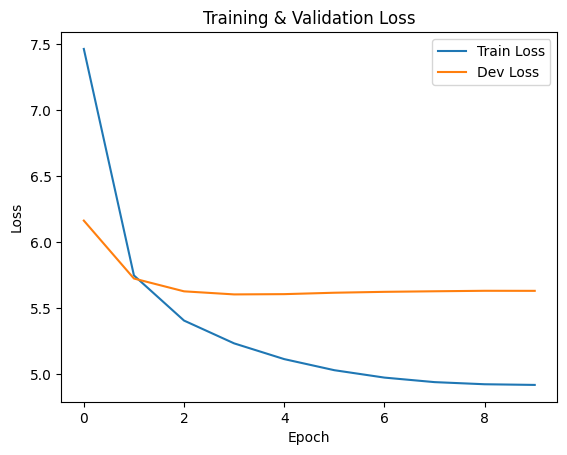

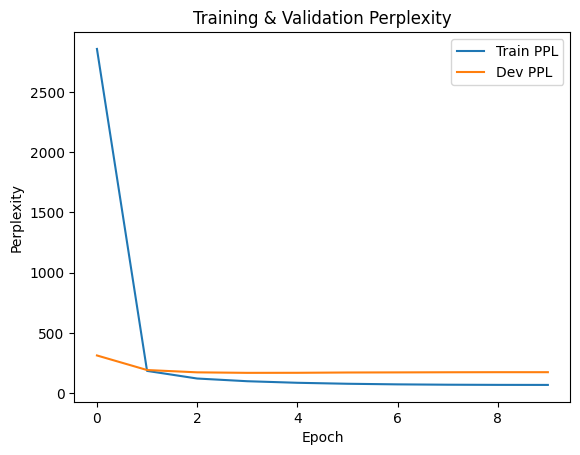

Model saved to /kaggle/working/transformer_shakespeare.pt


In [12]:
def main():
    # 1) Read data
    train_file = "/kaggle/input/shakespear/shakespear_train.txt"
    dev_file   = "/kaggle/input/shakespear/shakespear_dev.txt"
    test_file  = "test.txt"

    train_lines = read_lines_from_file(train_file)
    dev_lines   = read_lines_from_file(dev_file)
    
    # 2) Build tokenizer
    tokenizer = CustomTokenizer()
    tokenizer.build_vocab(train_lines + dev_lines)
    vocab_size = len(tokenizer)
    print(f"Vocab size = {vocab_size}")
    
    # 3) Prepare dataset
    train_x, train_y = prepare_dataset(train_file, tokenizer, seq_len=32)
    dev_x,   dev_y   = prepare_dataset(dev_file, tokenizer, seq_len=32)
    print("train_x shape:", train_x.shape, "train_y shape:", train_y.shape)
    print("dev_x shape:", dev_x.shape, "dev_y shape:", dev_y.shape)

    # 4) Create the model
    d_model = 256
    num_heads = 16
    d_ff = 1024
    num_layers = 4
    dropout = 0.2
    pad_idx = tokenizer.token2idx[tokenizer.pad_token]
    model = TransformerLanguageModel(
        vocab_size=vocab_size,
        d_model=d_model,
        num_heads=num_heads,
        d_ff=d_ff,
        num_layers=num_layers,
        dropout=dropout,
        pad_idx=pad_idx
    )

    # 5) Train the model with label smoothing, LR scheduler, grad clipping, and optional curriculum
    epochs = 10
    batch_size = 64
    lr = 0.00002  
    train_losses, dev_losses, train_ppls, dev_ppls = train_model(
        train_x, train_y, dev_x, dev_y,
        model,
        tokenizer,
        epochs=epochs,
        batch_size=batch_size,
        lr=lr,
        pad_idx=pad_idx,
        smoothing=0.1,         # label smoothing
        warmup_ratio=0.1,      # 10% of total steps are warm-up
        weight_decay=1e-4      # L2 regularization
    )

    # 6) Plot the curves
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot(dev_losses, label="Dev Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(train_ppls, label="Train PPL")
    plt.plot(dev_ppls, label="Dev PPL")
    plt.xlabel("Epoch")
    plt.ylabel("Perplexity")
    plt.title("Training & Validation Perplexity")
    plt.legend()
    plt.show()

    # 7) Save final model
    model_save_path = "/kaggle/working/transformer_shakespeare.pt"
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

    # 8) Evaluate on test data if present
    if os.path.exists(test_file):
        test_x, test_y = prepare_dataset(test_file, tokenizer, seq_len=32)
        if test_x.size(0) > 0:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model.to(device)
            model.eval()
            test_loss, test_ppl = 0.0, 0.0
            test_count = 0
            def get_test_batches(x_data, y_data, bsz):
                for i in range(0, x_data.size(0), bsz):
                    yield x_data[i:i+bsz], y_data[i:i+bsz]

            criterion = LabelSmoothingLoss(0.1, vocab_size, ignore_index=pad_idx)
            for bx, by in get_test_batches(test_x, test_y, batch_size):
                bx, by = bx.to(device), by.to(device)
                with torch.no_grad():
                    logits = model(bx)
                    loss, ppl = calculate_loss_and_perplexity(logits, by, criterion, pad_idx=pad_idx)
                test_loss += loss.item()
                test_ppl += ppl
                test_count += 1
            test_loss /= test_count
            test_ppl /= test_count
            print(f"Test Loss: {test_loss:.4f}, Test PPL: {test_ppl:.2f}")

        # Sample generation from lines in test.txt
        test_lines = read_lines_from_file(test_file)
        for line in test_lines:
            prompt = line.strip()
            gen_text = generate_text(model, prompt, tokenizer, max_new_tokens=20)
            print(f"Prompt: {prompt}")
            print(f"Generated: {gen_text}")
            print("----")

if __name__ == "__main__":
    main()

In [ ]:
def calculate_loss_and_perplexity(logits, targets, criterion, pad_idx=0):
    """
    logits:  (batch_size, seq_len, vocab_size)
    targets: (batch_size, seq_len)
    criterion: a loss function (e.g., LabelSmoothingLoss)
    
    Returns: (loss, ppl) for this batch
    """
    batch_size, seq_len, vocab_size = logits.size()
    log_probs = F.log_softmax(logits.view(-1, vocab_size), dim=-1)
    loss = criterion(log_probs, targets.view(-1))

    # ignoring padding tokens
    mask = (targets.view(-1) != pad_idx)
    # Gather the correct token log-probs
    masked_log_probs = log_probs[mask, :]
    masked_targets = targets.view(-1)[mask]

    nll = -masked_log_probs[range(masked_log_probs.size(0)), masked_targets].mean().item()
    ppl = math.exp(nll)
    return loss, ppl

def inference(model_path, test_file, tokenizer, pad_idx=0, max_new_tokens=20, batch_size=32):
    """
    1) Loads the pretrained model from 'model_path'
    2) Reads and preprocesses 'test_file'
    3) Generates 'max_new_tokens' tokens for each line in test_file
    4) Calculates perplexity on the test set
    """
    # 1) Loading the pretrained model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # re-instantiating the same model architecture used during training:
    d_model = 256
    num_heads = 16
    d_ff = 1024
    num_layers = 4
    dropout = 0.2
    
    model = TransformerLanguageModel(
        vocab_size=len(tokenizer),
        d_model=d_model,
        num_heads=num_heads,
        d_ff=d_ff,
        num_layers=num_layers,
        dropout=dropout,
        pad_idx=pad_idx
    )
    # Loading the weights
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # 2) Read and preprocess the test file
    if not os.path.exists(test_file):
        print(f"Test file '{test_file}' not found.")
        return
    
    test_lines = read_lines_from_file(test_file)
    # Prepare dataset
    test_x, test_y = prepare_dataset(test_file, tokenizer, seq_len=32)
    if test_x.size(0) == 0:
        print("No data found in test file (after tokenization).")
        return

    # 3) Generate tokens for each line
    print("\n--- Generation on each test line ---")
    for line in test_lines:
        prompt = line.strip()
        gen_text = generate_text(model, prompt, tokenizer, max_new_tokens=max_new_tokens)
        print(f"Prompt: {prompt}")
        print(f"Generated: {gen_text}")
        print("----")

    # 4) Calculate perplexity on the entire test set ---
    criterion = LabelSmoothingLoss(smoothing=0.1, vocab_size=len(tokenizer), ignore_index=pad_idx)

    test_loss, test_ppl = 0.0, 0.0
    test_count = 0
    
    def get_test_batches(x_data, y_data, bsz):
        for i in range(0, x_data.size(0), bsz):
            yield x_data[i:i+bsz], y_data[i:i+bsz]

    with torch.no_grad():
        for bx, by in get_test_batches(test_x, test_y, batch_size):
            bx, by = bx.to(device), by.to(device)
            logits = model(bx)  # (batch, seq, vocab)
            loss, ppl = calculate_loss_and_perplexity(logits, by, criterion, pad_idx=pad_idx)
            test_loss += loss.item()
            test_ppl += ppl
            test_count += 1

    test_loss /= test_count
    test_ppl  /= test_count
    print(f"\n--- Test Metrics ---")
    print(f"Test Loss: {test_loss:.4f}, Test Perplexity: {test_ppl:.2f}\n")

def main():
    train_file = "/kaggle/input/shakespear/shakespear_train.txt"
    dev_file   = "/kaggle/input/shakespear/shakespear_dev.txt"
    
    train_lines = read_lines_from_file(train_file)
    dev_lines   = read_lines_from_file(dev_file)

    tokenizer = CustomTokenizer()
    tokenizer.build_vocab(train_lines + dev_lines)

    model_save_path = "/kaggle/working/transformer_shakespeare.pt"
    test_file = "/kaggle/input/shakespear/shakespear_dev.txt"
    inference(model_save_path, test_file, tokenizer, pad_idx=tokenizer.token2idx["<PAD>"])

if __name__ == "__main__":
    main()